# Noisey VQE Simulation of Trihydrogen Cation (H₃⁺)

This notebook applies the **Variational Quantum Eigensolver (VQE)** algorithm to compute the **ground state energy of the trihydrogen cation (H₃⁺)** using a **noisy quantum simulator** and an **ansatz including both single and double excitations**. The simulation is implemented using PennyLane’s quantum chemistry tools.

### Key Features:
- **Molecular Setup**: Builds the H₃⁺ geometry and generates the qubit-based molecular Hamiltonian using the STO-3G basis.
- **Ansatz Construction**: Combines **single and double excitations** following the UCCSD framework.
- **Optimization Strategy**: Uses the **Adam optimizer** to iteratively minimize the expectation value of the Hamiltonian.
- **Results Visualization**:
  - Convergence plot of energy vs. iteration.
  - Quantum state decomposition into basis states and amplitudes.
  - Bar plot of the most significant basis states in the final statevector.

### Purpose:
To simulate the ground state of trihydrogen cation using a fully unitary coupled cluster approach in a **noisy setting**, offering a reference baseline for:
- Comparing single vs. double excitation contributions
- Evaluating optimizer performance

In [ ]:
import pennylane as qml                  # Quantum circuit builder and device management
from pennylane import numpy as np        # Not regular NumPy, but similar and supports automatic differentiation
from pennylane import qchem              # Quantum chemistry module used to define molecule Hamiltonians
from pennylane.qchem import excitations  # Single and double excitations used in the UCCSD ansatz
import matplotlib.pyplot as plt
import sys, os, json
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from vqe.vqe_utils import IMG_DIR, excitation_ansatz, get_optimizer, set_seed, make_run_config_dict, run_signature, find_existing_run, save_run_record, ensure_dirs, build_run_filename

# Create folders if needed
ensure_dirs()

# Reproducible runs
seed = 0
set_seed(seed)

# Define the atoms in the trihydrogen cation (H₃⁺)
symbols = ["H", "H", "H"]

# Define coordinates (in Ångströms)
# Approximate equilateral triangle configuration
coordinates = np.array([
    [0.000000,  1.000000,  0.000000],   # Hydrogen 1
    [-0.866025, -0.500000, 0.000000],   # Hydrogen 2
    [ 0.866025, -0.500000, 0.000000]    # Hydrogen 3
])

# Define the H₃⁺ Hamiltonian and the number of qubits required
# Default STO-3G basis set; note the +1 charge
basis = "STO-3G"
hamiltonian, qubits = qchem.molecular_hamiltonian(symbols, coordinates, charge=+1, basis=basis)

# Which orbitals are occupied (1) or unoccupied (0) in the mean-field (Hartree-Fock) solution
electrons = 2  # Total electrons in H₃⁺
hf = qchem.hf_state(electrons=electrons, orbitals=qubits)

# Define the number of required quantum wires / logical qubits
num_wires = qubits

# Optimizer parameters
optimizer_name = "Adam"
max_iterations = 50
stepsize = 0.2

# Noise parameters
depolarizing_prob = 0.02
amplitude_damping_prob = 0.04



Running VQE with single excitations...

[saved] Adam: H3+_Noisy_single_Adam_s0__7f670bdf291b
[mirrored] /workspaces/Variational_Quantum_Eigensolver/src/../notebooks/results/H3+_Noisy_single_Adam_s0__7f670bdf291b.json

Running VQE with double excitations...

[saved] Adam: H3+_Noisy_double_Adam_s0__f8eccb84958e
[mirrored] /workspaces/Variational_Quantum_Eigensolver/src/../notebooks/results/H3+_Noisy_double_Adam_s0__f8eccb84958e.json

Running VQE with both excitations...

[saved] Adam: H3+_Noisy_both_Adam_s0__a73165dba932
[mirrored] /workspaces/Variational_Quantum_Eigensolver/src/../notebooks/results/H3+_Noisy_both_Adam_s0__a73165dba932.json


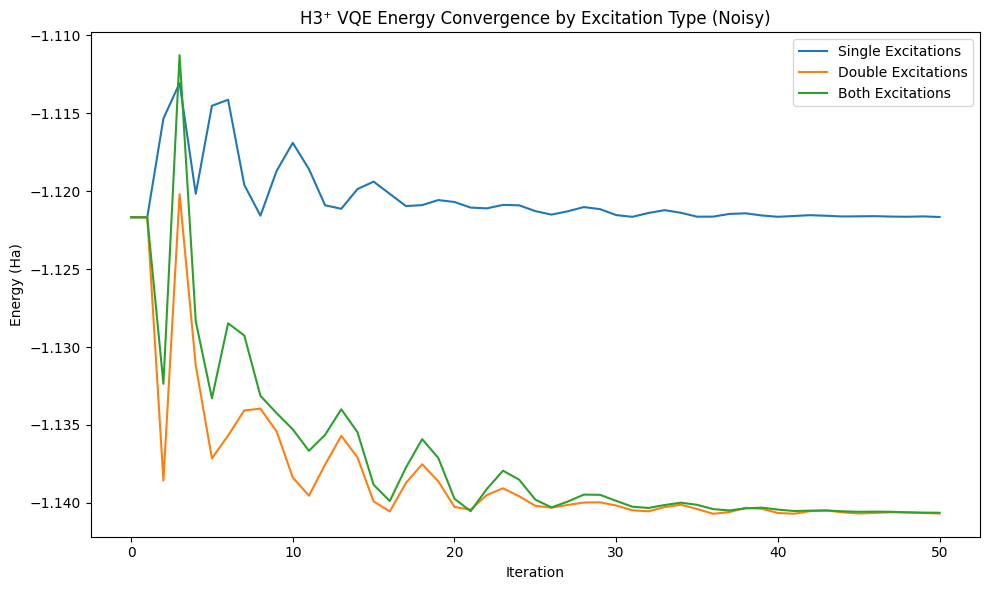

In [2]:
# Create quantum device simulator backend
dev = qml.device("default.mixed",  # Noisy state vector simulator
                 wires=num_wires)


@qml.qnode(dev)  # Transforms exp_energy below into a quantum node
def exp_energy(state):
    qml.BasisState(np.array(state), wires=range(num_wires))

    # Return the expectation value of the molecular Hamiltonian
    return qml.expval(hamiltonian)

# Generate excitation indices for H₃⁺
singles, doubles = excitations(electrons, qubits)

# Convert excitation indices from lists to tuples (required by PennyLane)
singles = [tuple(ex) for ex in singles]
doubles = [tuple(ex) for ex in doubles]

# General-purpose cost function for single/double/both excitations
def get_cost_function(excitation_type):
    @qml.qnode(dev, diff_method="finite-diff")
    def cost_fn(params):
        if excitation_type == "single":
            selected_excitations = (singles, [])
        elif excitation_type == "double":
            selected_excitations = ([], doubles)
        else:
            selected_excitations = (singles, doubles)

        excitation_ansatz(
            params,
            wires=range(num_wires),
            hf_state=hf,
            excitations=selected_excitations,
            excitation_type=excitation_type
        )

        for w in range(num_wires):
            qml.DepolarizingChannel(depolarizing_prob, wires=w)
            qml.AmplitudeDamping(amplitude_damping_prob, wires=w)

        return qml.expval(hamiltonian)
    
    return cost_fn

def run_vqe_with_cache_for_excitation(excitation_type, stepsize, max_iterations):
    # Ansatz description for logging
    if excitation_type == "single":
        ansatz_desc = "UCC singles"
        selected_excitations = ("single",)
        n_params = len(singles)
    elif excitation_type == "double":
        ansatz_desc = "UCC doubles"
        selected_excitations = ("double",)
        n_params = len(doubles)
    else:
        ansatz_desc = "UCC singles+doubles"
        selected_excitations = ("both",)
        n_params = len(singles) + len(doubles)

    # Build the cost function specialized to this excitation type
    cost_fn = get_cost_function(excitation_type)

    # Build configuration and signature
    cfg = make_run_config_dict(
        symbols=symbols,
        coordinates=coordinates,
        basis=basis,
        ansatz_desc=ansatz_desc,
        optimizer_name=optimizer_name,
        stepsize=stepsize,
        max_iterations=max_iterations,
        seed=seed,
        noisy=True,
        depolarizing_prob=0.02,
        amplitude_damping_prob=0.04
    )

    cfg["excitation_type"] = excitation_type  # Ensure unique hash per type

    # Canonical file name: readable prefix and signature
    sig = run_signature(cfg)
    fname = build_run_filename(f"H3+_Noisy_{excitation_type}", optimizer_name, seed, sig)
    existing = find_existing_run(sig)

    if existing:
        # Load results if this configuration has been run before
        with open(existing) as f:
            rec = json.load(f)
        print(f"[reuse] {excitation_type}: loaded {existing}")
        energy = rec["energies"]
        if "final_params" in rec:
            params = np.array(rec["final_params"], requires_grad=True)
        elif "params_by_step" in rec and rec["params_by_step"]:
            params = np.array(rec["params_by_step"][-1], requires_grad=True)
        else:
            print(f"[reuse] {excitation_type}: No parameters stored; recomputing.")
            existing = None
    
    if not existing:
        # Compute results if this configuration has NOT been ran before
        opt = get_optimizer(optimizer_name, stepsize=stepsize)
        params = np.zeros(n_params, requires_grad=True)
        energy = [cost_fn(params)]
        for _ in range(max_iterations):
            params, e_prev = opt.step_and_cost(cost_fn, params)
            energy.append(e_prev)
        energy[-1] = float(cost_fn(params))

        run_record = {
            "timestamp": __import__("time").strftime("%Y-%m-%d %H:%M:%S"),
            "molecule": "H3+",
            "symbols": symbols,
            "geometry": coordinates.tolist(),
            "basis": basis,
            "electrons": electrons,
            "num_wires": num_wires,
            "excitation_type": excitation_type,
            "ansatz": ansatz_desc,
            "optimizer": {
                "name": optimizer_name,
                "stepsize": stepsize,
                "iterations_planned": max_iterations,
                "iterations_ran": len(energy) - 1,
            },
            "seed": seed,
            "energies": [float(e) for e in energy],
            "final_params": [float(x) for x in params],
            "config_hash": sig,
            "noisy": True,
            "depolarizing_prob": depolarizing_prob,
            "amplitude_damping_prob": amplitude_damping_prob,
        }

        persisted = save_run_record(fname, run_record)
        print(f"\n[saved] {optimizer_name}: {fname}")
        print(f"[mirrored] {persisted}")

    return {"energy": energy, "params": params}

excitation_types = ["single", "double", "both"]
results = {}
for exc_type in excitation_types:
    print(f"\nRunning VQE with {exc_type} excitations...")
    results[exc_type] = run_vqe_with_cache_for_excitation(
        excitation_type=exc_type,
        stepsize=stepsize,
        max_iterations=max_iterations,
    )

# Plot convergence for each excitation type
plt.figure(figsize=(10, 6))
for exc_type in excitation_types:
    plt.plot(results[exc_type]["energy"], label=f"{exc_type.capitalize()} Excitations")

plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H3⁺ VQE Energy Convergence by Excitation Type (Noisy)")
plt.legend()
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/H3plus_Noisy.png", dpi=300)
plt.show()

In [3]:
# Define a helper to construct a fresh QNode for each excitation type
def get_ground_state_qnode(excitation_type, selected_excitations):
    @qml.qnode(dev, diff_method="finite-diff")
    def circuit(params):
        excitation_ansatz(
            params,
            wires=range(num_wires),
            hf_state=hf,
            excitations=selected_excitations,
            excitation_type=excitation_type
        )

        # Simple noise: 2% depolarizing, 4% amplitude damping
        for w in range(num_wires):
            qml.DepolarizingChannel(depolarizing_prob, wires=w)
            qml.AmplitudeDamping(amplitude_damping_prob, wires=w)

        return qml.state()
    return circuit

# Print final energies and ground states for each excitation type
for exc_type in excitation_types:
    final_E = results[exc_type]["energy"][-1]
    final_params = results[exc_type]["params"]

    print("-" * 90)
    print(f"\nFinal energy ({exc_type}): {final_E:.8f} Ha")

    # Split parameters and define excitations
    if exc_type == "single":
        theta_singles = final_params
        theta_doubles = np.array([])
        selected_excitations = (singles, [])
    elif exc_type == "double":
        theta_singles = np.array([])
        theta_doubles = final_params
        selected_excitations = ([], doubles)
    else:
        num_singles = len(singles)
        theta_singles = final_params[:num_singles]
        theta_doubles = final_params[num_singles:]
        selected_excitations = (singles, doubles)

    print(f"Final single excitation parameters: {theta_singles}")
    print(f"Final double excitation parameters: {theta_doubles}")

    final_rho = get_ground_state_qnode(exc_type, selected_excitations)(final_params)  # Density matrix
    diag_elements = np.diag(final_rho)

    # Extract non-zero amplitude basis states
    threshold = 1e-2  # Recommended smaller threshold to capture all significant amplitudes
    non_zero_indices = np.where(np.abs(diag_elements) > threshold)[0]
    non_zero_values = diag_elements[non_zero_indices]

    # Build the full ket notation string
    ket_terms = []
    for idx, amp in enumerate(diag_elements):
        binary_state = f"|{idx:0{num_wires}b}⟩"
        if amp > threshold:
            ket_terms.append(f"({amp:.4f}|{idx:0{num_wires}b}⟩)")
    ket_notation = " + ".join(ket_terms)

    print(f"\nGround state of H₃⁺ with {exc_type} excitations:\n|ψ⟩ = {ket_notation}")


------------------------------------------------------------------------------------------

Final energy (single): -1.12165384 Ha
Final single excitation parameters: [-0.00856513 -0.00493592 -0.00785808 -0.006848  ]
Final double excitation parameters: []

Ground state of H₃⁺ with single excitations:
|ψ⟩ = (0.0475+0.0000j|010000⟩) + (0.0475+0.0000j|100000⟩) + (0.8521+0.0000j|110000⟩) + (0.0110+0.0000j|110001⟩) + (0.0110+0.0000j|110010⟩) + (0.0110+0.0000j|110100⟩) + (0.0110+0.0000j|111000⟩)
------------------------------------------------------------------------------------------

Final energy (double): -1.14068446 Ha
Final single excitation parameters: []
Final double excitation parameters: [0.16717049 0.00262429 0.00261364 0.16729667]

Ground state of H₃⁺ with double excitations:
|ψ⟩ = (0.0468+0.0000j|010000⟩) + (0.0468+0.0000j|100000⟩) + (0.8403+0.0000j|110000⟩) + (0.0109+0.0000j|110001⟩) + (0.0109+0.0000j|110010⟩) + (0.0109+0.0000j|110100⟩) + (0.0109+0.0000j|111000⟩)
----------------